<a href="https://colab.research.google.com/github/ikonushok/My_studying_Data-Science-and-Neyro-Nets-on-Python/blob/master/%D0%94%D0%97_5_Pro2_%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%B2%D0%BB%D0%B8%D1%8F%D0%BD%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BE%D0%B2_%D1%81%D0%BB%D0%BE%D0%B2_%D0%BD%D0%B0_%D1%82%D0%BE%D1%87%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PRO задание. Вариант 2
Сделайте оценку того, как блоки слов в словаре влияют на точность классификации (на любой базе, например, распознавание писателей). Для этого выполните следующее:
* Сформируйте словарь.
* Используйте первые 50000 слов.
* Разбейте все слова на блоки по 100 слов последовательно.
* Поочередно отключайте блоки по одному, то есть сделайте так, чтобы эти слова
не использовались при обучении сети, например, их индексы всегда
приравнивались к 0.
* Оцените, как меняется точность классификации на проверочной выборке. ● Сделайте выводы, какие блоки слов влияют в плюс, а какие в минус.
* Соберите итоговую подборку слов, в которую войдут только те блоки по 100 слов, которые улучшили точность (исключение которых давало падение точности).
* Обучите сеть только на этих блоках слов.
* Оцените изменение точности в сравнении с обучением на полном словаре (первые
50000 слов).

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Embedding, Flatten, Activation # сверточные слои
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN, Bidirectional # рекуррентные слои
from tensorflow.keras.optimizers import Adam, RMSprop

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers.merge import concatenate
from keras.utils import plot_model
import time # чтобы зачсечь время

import matplotlib.pyplot as plt # Для вывода графиков
%matplotlib inline

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #инструменты предобработки текста от кераса
from sklearn.model_selection import train_test_split #модуль для разбиения данных на обучающую и тестовую выборки
from tensorflow.keras import utils # Для работы с категориальными данными
import numpy as np #библиотека для работы с массивами данных
import pandas as pd #библиотека для обработки и анализа данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Подготовка данных

## Чтение текстов

In [ ]:
# Чтение файлов
import os
os.chdir('/content/drive/My Drive/Занятие_4_Обработка текстов с помощью нейросетей/data/Тексты писателей')
os.listdir()

['(О. Генри) Обучающая_50 вместе.txt',
 '(Клиффорд_Саймак) Тестовая_2 вместе.txt',
 '(Булгаков) Обучающая_5 вместе.txt',
 '(Макс Фрай) Обучающая_5 вместе.txt',
 '(О. Генри) Тестовая_20 вместе.txt',
 '(Клиффорд_Саймак) Обучающая_5 вместе.txt',
 '(Булгаков) Тестовая_2 вместе.txt',
 '(Макс Фрай) Тестовая_2 вместе.txt',
 '(Рэй Брэдберри) Тестовая_8 вместе.txt',
 '(Стругацкие) Тестовая_2 вместе.txt',
 '(Рэй Брэдберри) Обучающая_22 вместе.txt',
 '(Стругацкие) Обучающая_5 вместе.txt',
 'best_modelED_Adam_15000_20.h5',
 'shared_input_layer.png',
 'model.png']

In [ ]:
# функция чтения текстов
def readText(fileName):
  f = open(fileName, 'r') # открыли файл
  text = f.read() # считали файл
  text = text.replace("\n", " ")  # заменили переносы строк на пробелы

  return text

# Интересующие нас авторы
className = ["Генри", "Стругацкие", "Булгаков", "Клиффорд", "Макс", "Брэдберри"] 
nClasses = len(className) # посчитали количество авторов (число классов)

# загружаем тексы в базы
trainText = []
testText = []

for i in className:
  for j in os.listdir():
    if i in j:
      if 'Обучающая' in j:
        trainText.append(readText(j))
        print('train: ', j)
      if 'Тестовая' in j:
        testText.append(readText(j))
        print('Test: ', j)

print('\nЭлементов в train: ', len(trainText), '\nЭлементов в test: ', len(testText))

train:  (О. Генри) Обучающая_50 вместе.txt
Test:  (О. Генри) Тестовая_20 вместе.txt
Test:  (Стругацкие) Тестовая_2 вместе.txt
train:  (Стругацкие) Обучающая_5 вместе.txt
train:  (Булгаков) Обучающая_5 вместе.txt
Test:  (Булгаков) Тестовая_2 вместе.txt
Test:  (Клиффорд_Саймак) Тестовая_2 вместе.txt
train:  (Клиффорд_Саймак) Обучающая_5 вместе.txt
train:  (Макс Фрай) Обучающая_5 вместе.txt
Test:  (Макс Фрай) Тестовая_2 вместе.txt
Test:  (Рэй Брэдберри) Тестовая_8 вместе.txt
train:  (Рэй Брэдберри) Обучающая_22 вместе.txt

Элементов в train:  6 
Элементов в test:  6


## Функции создания словарей и перевода данных в индексы

In [ ]:
# разрезаем текст на вектора

def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = []
  wordsLen = len(wordIndexes)
  index = 0

  while (index + xLen <= wordsLen):
    xSample.append(wordIndexes[index:index+xLen])
    index += step
  
  return xSample

In [ ]:
# функции формирования test и train  выборок

def createSetsMultiClasses(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # задаем количество классов выборки
  classesXSamples = []        # здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна(например 6 по 1341*1000)"
  for wI in wordIndexes:      # для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна(например 15779*1000)"
  ySamples = [] # здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной число классов"
  
  for t in range(nClasses):  # в диапазоне кол-ва классов
    xT = classesXSamples[t]  # берем очередной текст вида "кол-во окон в тексте*длину окна"(например 1341*1000)
    for i in range(len(xT)): # и каждое его окно
      xSamples.append(xT[i]) # добавляем в общий список выборки
    
    # Формируем ySamples по номеру класса
    currY = utils.to_categorical(t, nClasses) # текущий класс переводится в вектор длиной 6 вида [0.0.0.1.0.0.]
    for i in range(len(xT)): # на каждое окно выборки 
      ySamples.append(currY) # добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples)   # функция возвращает выборку и соответствующие векторы классов

## Создание обучающей выборки

In [ ]:
# Преобразование текстовых данных в числовые/векторные
maxWordsCount = 50000 # определяем максимальное количество уникальных слов для обучения

tokenizer = Tokenizer(num_words=maxWordsCount,
                      filters='…»«0123456789–—!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\xa0–\ufeff',
                      lower = True,
                      split=' ', char_level=False, oov_token = 'unknown')
# выше задаем параметры:
# (num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
# (filters='…!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n«»…') - избавляемся от ненужных символов
# (lower=True) - приводим слова к нижнему регистру
# (split=' ') - разделяем слова по пробелу
# (char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(trainText) # токенизировали текст

items = list(tokenizer.word_index.items()) # достали индексы слов
print('Число уникальных слов: ', len(items), '\n', items[250], '\n',  items[11:20], '\n',items[(len(items)-5):])

# преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

# базовые параметры
xLen = 10000 # длина отрезка, по которому анализируем
step = 500 # шаг разбиения xLen на вектора

print("\nВзглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[5][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[5][:25], '\n')

Число уникальных слов:  132505 
 ('видел', 251) 
 [('то', 12), ('это', 13), ('но', 14), ('все', 15), ('у', 16), ('по', 17), ('его', 18), ('к', 19), ('так', 20)] 
 [('потерян', 132501), ('расплывающиеся', 132502), ('миллионе', 132503), ('зияющая', 132504), ('ничтонавстречу', 132505)]

Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ﻿451° по Фаренгейту   ДОНУ КОНГДОНУ С БЛАГОДАРНОСТЬЮ   Если тебе дадут линованную бумаг
Он же в виде последовательности индексов:  [1, 17, 28150, 4294, 1, 8, 14441, 41, 74, 6032, 1, 2124, 8140, 23374, 47417, 1, 42029, 805, 23193, 2, 20990, 10017, 30, 5335, 262] 



In [ ]:
  xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку
  testWordIndexes = tokenizer.texts_to_sequences(testText)   # проверочные тесты в индексы

# Нейронные сети

## Embedding + Dense сеть


In [ ]:
  # Нейросеть
  input_layer = Input(shape=(xLen, ))
  ED_1 = Embedding(maxWordsCount, 50, input_length = xLen)(input_layer)
  ED_2 = SpatialDropout1D(0.4)(ED_1)
  ED_3 = Flatten()(ED_2)
  ED_4 = Dense(6, activation='softmax')(ED_3)
  model = Model(inputs=input_layer, outputs=ED_4)

Точность распознавания сети без отключенных блоков (эталонная): 
Epoch 1/100
107/107 [==============================] - 7s 63ms/step - loss: 6.8043e-04 - accuracy: 1.0000 - val_loss: 0.7478 - val_accuracy: 0.7033
Epoch 2/100
107/107 [==============================] - 6s 57ms/step - loss: 2.1774e-04 - accuracy: 1.0000 - val_loss: 0.7184 - val_accuracy: 0.7163
Epoch 3/100
107/107 [==============================] - 6s 57ms/step - loss: 1.1406e-04 - accuracy: 1.0000 - val_loss: 0.6911 - val_accuracy: 0.7309
Epoch 4/100
107/107 [==============================] - 6s 57ms/step - loss: 8.1817e-05 - accuracy: 1.0000 - val_loss: 0.6587 - val_accuracy: 0.7561
Epoch 5/100
107/107 [==============================] - 6s 55ms/step - loss: 5.7453e-05 - accuracy: 1.0000 - val_loss: 0.6593 - val_accuracy: 0.7439
Epoch 6/100
107/107 [==============================] - 6s 55ms/step - loss: 4.1148e-05 - accuracy: 1.0000 - val_loss: 0.6526 - val_accuracy: 0.7480


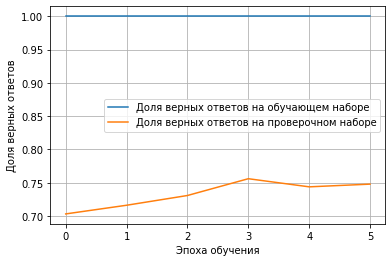


Время обработки: 40.19c

maxWordsCount =  50000 val_accuracy =  0.7560975551605225


In [ ]:
print('Точность распознавания сети без отключенных блоков (эталонная): ')
cur_time = time.time() # засекаем время

data = [] #Сюда будет вестись запись результатов эксперимента

# формирование выборок
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку

# Нейросеть
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose = 0,  restore_best_weights = True)
Checkpoint = ModelCheckpoint('/content/drive/My Drive/Занятие_5_RNN+CNN для текстов/data/modelNORMA.h5', monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
history = model.fit(xTrain, yTrain, epochs=100, verbose = 1, callbacks = [early_stopping, Checkpoint], validation_data = (xTest, yTest))

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.grid()
plt.show()

#Проверяем результаты работы сети
print('\nВремя обработки: ', round(time.time() - cur_time, 2), 'c', sep='') # смотрим время
print('\nmaxWordsCount = ', maxWordsCount, 'val_accuracy = ', max(history.history['val_accuracy']))

data = data + [[0, maxWordsCount, max(history.history['val_accuracy'])]]
results = pd.DataFrame(data, columns = ['blockBegin', 'blockEnd', 'predict'])
results.to_excel('/content/drive/My Drive/Занятие_5_RNN+CNN для текстов/data/results_ДЗ_5_Pro2.xlsx', index=True)



In [ ]:
# Цикл отключения блоков по 100 слов
cur_time = time.time() # засекаем время

lenBlock = int(input('Введите длину отключаемых блоков: '))

n = 0
while n+lenBlock <= maxWordsCount: # отключаем блоки пока не кончатся используемые слова
  for i in range(len(trainText)): # выбор класса
    for j in range (xLen): # отключение блока внутри каждого класса обучающей выборки
      if (n <= trainWordIndexes[i][j] < (n+lenBlock)): trainWordIndexes[i][j] = 0

    #print("\nПроверка отключения блоков:")
    #print(i, n, '-', n+lenBlock)
    #print("В виде оригинального текста:              ", trainText[i][:87])
    #print("Он же в виде последовательности индексов: ", trainWordIndexes[i][:25], '\n')

  # формирование выборок
  xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку

  # Нейросеть
  model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
  early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose = 0,  restore_best_weights = True)
  history = model.fit(xTrain, yTrain, epochs=100, verbose = 0, callbacks = early_stopping, validation_data = (xTest, yTest))

  #Проверяем результаты работы сети
  print('maxWordsCount = ', maxWordsCount, 'Отключен блок: ', n, '-', n+lenBlock-1, 'Точночть классификации = ', 'val_accuracy = ', max(history.history['val_accuracy']))
  data = data + [[n, n+lenBlock, max(history.history['val_accuracy'])]]

  n += lenBlock
  # Опять наводим порядок в индексах
  trainWordIndexes = tokenizer.texts_to_sequences(trainText) # обучающие тесты в индексы

print('\nВремя обработки: ', round(time.time() - cur_time, 2), 'c', sep='') # смотрим время
print()

results = pd.DataFrame(data, columns = ['blockBegin', 'blockEnd', 'predict'])
results.to_excel('/content/drive/My Drive/Занятие_5_RNN+CNN для текстов/data/results_ДЗ_5_Pro2.xlsx', index=True)
#results



Введите длину отключаемых блоков: 100
maxWordsCount =  50000 Отключен блок:  0 - 99 Точночть классификации =  val_accuracy =  0.6918699145317078
maxWordsCount =  50000 Отключен блок:  100 - 199 Точночть классификации =  val_accuracy =  0.7650406360626221
maxWordsCount =  50000 Отключен блок:  200 - 299 Точночть классификации =  val_accuracy =  0.7861788868904114
maxWordsCount =  50000 Отключен блок:  300 - 399 Точночть классификации =  val_accuracy =  0.8073170781135559
maxWordsCount =  50000 Отключен блок:  400 - 499 Точночть классификации =  val_accuracy =  0.7918699383735657
maxWordsCount =  50000 Отключен блок:  500 - 599 Точночть классификации =  val_accuracy =  0.795121967792511
maxWordsCount =  50000 Отключен блок:  600 - 699 Точночть классификации =  val_accuracy =  0.7869918942451477
maxWordsCount =  50000 Отключен блок:  700 - 799 Точночть классификации =  val_accuracy =  0.7934959530830383
maxWordsCount =  50000 Отключен блок:  800 - 899 Точночть классификации =  val_accurac

# Отключение "ПЛОХИХ" блоков

In [ ]:
# загружаем файл с базой результатов эксперимента
xl = pd.ExcelFile('/content/drive/My Drive/Занятие_5_RNN+CNN для текстов/data/results_ДЗ_5_Pro2.xlsx')

In [ ]:
print(xl.sheet_names) # печатаем именя столбцов
df_results = xl.parse('Sheet1') # загружаем данные в DataFrame
print(df_results.head())
print()
print(df_results.predict)
print()
print(df_results.index)
print('Число строк включая названия = ', len(df_results.index))

['Sheet1']
   Unnamed: 0  blockBegin  blockEnd   predict
0           0           0     50000  0.756098
1           1           0       100  0.691870
2           2         100       200  0.765041
3           3         200       300  0.786179
4           4         300       400  0.807317

0      0.756098
1      0.691870
2      0.765041
3      0.786179
4      0.807317
         ...   
496    0.692683
497    0.689431
498    0.686992
499    0.686179
500    0.686179
Name: predict, Length: 501, dtype: float64

RangeIndex(start=0, stop=501, step=1)
Число строк включая названия =  501


In [ ]:
# выделим эталонное значение (последнее в базе = результат НС без отключенных блоков):
norma = df_results.predict[0]
norma

0.7560975551605225

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку

print("\nВзглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[5][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[5][:25], '\n')


Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ﻿451° по Фаренгейту   ДОНУ КОНГДОНУ С БЛАГОДАРНОСТЬЮ   Если тебе дадут линованную бумаг
Он же в виде последовательности индексов:  [1, 17, 28150, 4294, 1, 8, 14441, 41, 74, 6032, 1, 2124, 8140, 23374, 47417, 1, 42029, 805, 23193, 2, 20990, 10017, 30, 5335, 262] 



In [ ]:
worstBlocks = []
for n in range(1, len(df_results.index)):
  if df_results.predict[n] > norma: # отключаю ПЛОХИЕ блоки для второй проверки
  # если отключение блока дало результат > нормы, то блок "плохой" и его надо отключить
    print ('Норма = ', norma, 'Результат блока = ', df_results.predict[n], 'Блок для удаления: ', df_results.blockBegin[n], '-', df_results.blockEnd[n])
    for i in range(len(trainText)): # выбор класса
      for j in range (xLen): # отключение блока внутри каждого класса обучающей выборки
        if (df_results.blockBegin[n] <= trainWordIndexes[i][j] < df_results.blockEnd[n]): trainWordIndexes[i][j] = 0

Норма =  0.7560975551605225 Результат блока =  0.7650406360626221 Блок для удаления:  100 - 200
Норма =  0.7560975551605225 Результат блока =  0.7861788868904114 Блок для удаления:  200 - 300
Норма =  0.7560975551605225 Результат блока =  0.8073170781135559 Блок для удаления:  300 - 400
Норма =  0.7560975551605225 Результат блока =  0.7918699383735657 Блок для удаления:  400 - 500
Норма =  0.7560975551605225 Результат блока =  0.795121967792511 Блок для удаления:  500 - 600
Норма =  0.7560975551605225 Результат блока =  0.7869918942451477 Блок для удаления:  600 - 700
Норма =  0.7560975551605225 Результат блока =  0.7934959530830383 Блок для удаления:  700 - 800
Норма =  0.7560975551605225 Результат блока =  0.7829268574714661 Блок для удаления:  800 - 900
Норма =  0.7560975551605225 Результат блока =  0.7804877758026123 Блок для удаления:  900 - 1000
Норма =  0.7560975551605225 Результат блока =  0.7756097316741943 Блок для удаления:  1000 - 1100
Норма =  0.7560975551605225 Результат 

In [ ]:
print("Взглянем на фрагмент обучающего текста ПОСЛЕ ОТКЛЮЧЕНИЯ ПЛОХИХ БЛОКОВ:")
print("В виде оригинального текста:              ", trainText[5][:100])
print("Он же в виде последовательности индексов: ", trainWordIndexes[5][:40], '\n')

Взглянем на фрагмент обучающего текста ПОСЛЕ ОТКЛЮЧЕНИЯ ПЛОХИХ БЛОКОВ:
В виде оригинального текста:               ﻿451° по Фаренгейту   ДОНУ КОНГДОНУ С БЛАГОДАРНОСТЬЮ   Если тебе дадут линованную бумагу, пиши попер
Он же в виде последовательности индексов:  [1, 17, 28150, 0, 1, 8, 14441, 41, 74, 0, 1, 0, 8140, 23374, 47417, 1, 42029, 0, 23193, 2, 20990, 10017, 30, 5335, 0, 12, 7244, 9252, 0, 11, 0, 27149, 0, 11, 32, 1, 2, 13119, 11100, 38595] 



----
Отключение "ПЛОХИХ" блоков

Точность распознавания сети С ОТКЛЮЧЕННЫМИ "ПЛОХИМИ" БЛОКАМИ: 
Epoch 1/100
107/107 [==============================] - 6s 59ms/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.8054 - val_accuracy: 0.7000
Epoch 2/100
107/107 [==============================] - 6s 58ms/step - loss: 6.1688e-04 - accuracy: 0.9997 - val_loss: 0.7745 - val_accuracy: 0.7163
Epoch 3/100
107/107 [==============================] - 6s 57ms/step - loss: 1.3866e-04 - accuracy: 1.0000 - val_loss: 0.7443 - val_accuracy: 0.7211
Epoch 4/100
107/107 [==============================] - 6s 57ms/step - loss: 1.0509e-04 - accuracy: 1.0000 - val_loss: 0.7562 - val_accuracy: 0.7130
Epoch 5/100
107/107 [==============================] - 6s 57ms/step - loss: 2.4413e-04 - accuracy: 1.0000 - val_loss: 0.7597 - val_accuracy: 0.7114


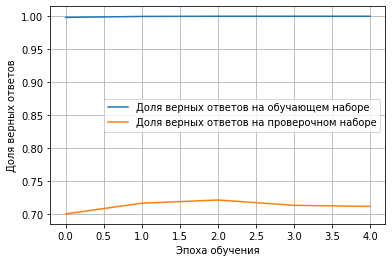


Время обработки: 35.1c

maxWordsCount =  50000 val_accuracy =  0.7211382389068604


In [ ]:
from keras.models import load_model

print('Точность распознавания сети С ОТКЛЮЧЕННЫМИ "ПЛОХИМИ" БЛОКАМИ: ')

cur_time = time.time() # засекаем время
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку

# Нейросеть
modelNORMA = load_model('/content/drive/My Drive/Занятие_5_RNN+CNN для текстов/data/modelNORMA.h5')
modelNORMA.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose = 0,  restore_best_weights = True)
history = modelNORMA.fit(xTrain, yTrain, epochs=100, verbose = 1, callbacks = early_stopping, validation_data = (xTest, yTest))

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.grid()
plt.show()

#Проверяем результаты работы сети
print('\nВремя обработки: ', round(time.time() - cur_time, 2), 'c', sep='') # смотрим время
print('\nmaxWordsCount = ', maxWordsCount, 'val_accuracy = ', max(history.history['val_accuracy']))

# Отключение "ХОРОШИХ" блоков

In [ ]:
# загружаем файл с базой результатов эксперимента
xl = pd.ExcelFile('/content/drive/My Drive/Занятие_5_RNN+CNN для текстов/data/results_ДЗ_5_Pro2.xlsx')

In [ ]:
print(xl.sheet_names) # печатаем именя столбцов
df_results = xl.parse('Sheet1') # загружаем данные в DataFrame
print(df_results.head())
print()
print(df_results.predict)
print()
print(df_results.index)
print('Число строк включая названия = ', len(df_results.index))

['Sheet1']
   Unnamed: 0  blockBegin  blockEnd   predict
0           0           0     50000  0.756098
1           1           0       100  0.691870
2           2         100       200  0.765041
3           3         200       300  0.786179
4           4         300       400  0.807317

0      0.756098
1      0.691870
2      0.765041
3      0.786179
4      0.807317
         ...   
496    0.692683
497    0.689431
498    0.686992
499    0.686179
500    0.686179
Name: predict, Length: 501, dtype: float64

RangeIndex(start=0, stop=501, step=1)
Число строк включая названия =  501


In [ ]:
# выделим эталонное значение (последнее в базе = результат НС без отключенных блоков):
norma = df_results.predict[0]
norma

0.7560975551605225

In [ ]:
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку

print("\nВзглянем на фрагмент обучающего текста:")
print("В виде оригинального текста:              ", trainText[5][:87])
print("Он же в виде последовательности индексов: ", trainWordIndexes[5][:25], '\n')


Взглянем на фрагмент обучающего текста:
В виде оригинального текста:               ﻿451° по Фаренгейту   ДОНУ КОНГДОНУ С БЛАГОДАРНОСТЬЮ   Если тебе дадут линованную бумаг
Он же в виде последовательности индексов:  [1, 17, 28150, 4294, 1, 8, 14441, 41, 74, 6032, 1, 2124, 8140, 23374, 47417, 1, 42029, 805, 23193, 2, 20990, 10017, 30, 5335, 262] 



In [ ]:
worstBlocks = []
for n in range(1, len(df_results.index)):
  if df_results.predict[n] < norma: # отключаю ХОРОШИЕ блки для второй проверки
  # если отключение блока дало результат < нормы, то блок "ХОРОШИЙ" и его НЕ надо отключить
    print ('Норма = ', norma, 'Результат блока = ', df_results.predict[n], 'Блок для удаления: ', df_results.blockBegin[n], '-', df_results.blockEnd[n])
    for i in range(len(trainText)): # выбор класса
      for j in range (xLen): # отключение блока внутри каждого класса обучающей выборки
        if (df_results.blockBegin[n] <= trainWordIndexes[i][j] < df_results.blockEnd[n]): trainWordIndexes[i][j] = 0

Норма =  0.7560975551605225 Результат блока =  0.6918699145317078 Блок для удаления:  0 - 100
Норма =  0.7560975551605225 Результат блока =  0.7544715404510498 Блок для удаления:  3400 - 3500
Норма =  0.7560975551605225 Результат блока =  0.7504065036773682 Блок для удаления:  3500 - 3600
Норма =  0.7560975551605225 Результат блока =  0.7487804889678955 Блок для удаления:  4700 - 4800
Норма =  0.7560975551605225 Результат блока =  0.7544715404510498 Блок для удаления:  5000 - 5100
Норма =  0.7560975551605225 Результат блока =  0.7528455257415771 Блок для удаления:  5200 - 5300
Норма =  0.7560975551605225 Результат блока =  0.7422764301300049 Блок для удаления:  5300 - 5400
Норма =  0.7560975551605225 Результат блока =  0.7552845478057861 Блок для удаления:  5400 - 5500
Норма =  0.7560975551605225 Результат блока =  0.7544715404510498 Блок для удаления:  5800 - 5900
Норма =  0.7560975551605225 Результат блока =  0.7528455257415771 Блок для удаления:  6300 - 6400
Норма =  0.7560975551605

In [ ]:
print("Взглянем на фрагмент обучающего текста ПОСЛЕ ОТКЛЮЧЕНИЯ ПЛОХИХ БЛОКОВ:")
print("В виде оригинального текста:              ", trainText[5][:100])
print("Он же в виде последовательности индексов: ", trainWordIndexes[5][:40], '\n')

Взглянем на фрагмент обучающего текста ПОСЛЕ ОТКЛЮЧЕНИЯ ПЛОХИХ БЛОКОВ:
В виде оригинального текста:               ﻿451° по Фаренгейту   ДОНУ КОНГДОНУ С БЛАГОДАРНОСТЬЮ   Если тебе дадут линованную бумагу, пиши попер
Он же в виде последовательности индексов:  [0, 0, 0, 4294, 0, 0, 0, 0, 0, 6032, 0, 2124, 0, 0, 0, 0, 0, 805, 0, 0, 0, 0, 0, 0, 262, 0, 0, 0, 615, 0, 949, 0, 701, 0, 0, 0, 0, 0, 0, 0] 



----
Отключение "ХОРОШИХ" блоков

Точность распознавания сети С ОТКЛЮЧЕННЫМИ "ХОРОШИМИ" БЛОКАМИ: 
Epoch 1/100
107/107 [==============================] - 6s 58ms/step - loss: 0.0218 - accuracy: 0.9950 - val_loss: 0.7819 - val_accuracy: 0.6959
Epoch 2/100
107/107 [==============================] - 6s 56ms/step - loss: 0.0063 - accuracy: 0.9977 - val_loss: 0.7759 - val_accuracy: 0.6846
Epoch 3/100
107/107 [==============================] - 6s 56ms/step - loss: 0.0019 - accuracy: 0.9991 - val_loss: 0.7569 - val_accuracy: 0.6951


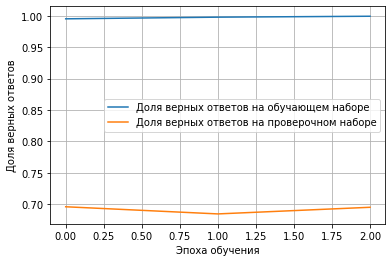


Время обработки: 22.18c

maxWordsCount =  50000 val_accuracy =  0.6959349513053894


In [ ]:
from keras.models import load_model

print('Точность распознавания сети С ОТКЛЮЧЕННЫМИ "ХОРОШИМИ" БЛОКАМИ: ')

cur_time = time.time() # засекаем время
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step) # извлекаем обучающую выборку

# Нейросеть
modelNORMA = load_model('/content/drive/My Drive/Занятие_5_RNN+CNN для текстов/data/modelNORMA.h5')
modelNORMA.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 2, verbose = 0,  restore_best_weights = True)
history = modelNORMA.fit(xTrain, yTrain, epochs=100, verbose = 1, callbacks = early_stopping, validation_data = (xTest, yTest))

plt.plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.grid()
plt.show()

#Проверяем результаты работы сети
print('\nВремя обработки: ', round(time.time() - cur_time, 2), 'c', sep='') # смотрим время
print('\nmaxWordsCount = ', maxWordsCount, 'val_accuracy = ', max(history.history['val_accuracy']))

# ВЫВОД
---
Результат несколько станный.. Улучшения нет. Вероятно, этот метод работает на больших точностях. Но оллаб не выдержит многократных запусков с maxWordsCount = 50000

------
В любом случае, после отключения ХОРОШИХ блоков, результат СЕРЬЕЗНО ухудшился